# Transforming pandas dataframe to prediction dataframe

In order to transform the pandas dataframe to a prediction table it is necessary to first following the steps in: Transforming graph data to pandas dataframe 2023.<br><br>
The goal of this notebook is to change the pandas dataframe to a prediction table were the contributors are on the rows and the community's are on the columns. If a contributor is member of a community it will show the value of 1.

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

To use some of the funtions used in this notebook you first need to download the Functions notebook, which is available in jupyter notebook and spyder.

In [3]:
%run Functions.ipynb

In [5]:
df = pd.read_csv('data_graph_matrix_2023.csv', index_col=0)

It is important to filter the acquired data in the pandas dataframe on the community's that are visible. So not private and not a demo/archived community. To get the data of the visibility of the community's follow:

In [6]:
df_vis = pd.read_csv('visibility_hubs_2023.csv', index_col=0)

find communitys that are closed and there corresponding group id. Every community in that group will be removed from the dataset

In [7]:
closed = []
for i in range(len(df_vis)):
    if df_vis['openAccess'].iloc[i] == False:
        closed.append(df_vis['ID'].iloc[i])

Get the group ID from the closed Space, by doing this every community that is part of that closed Space can be removed from the dataframe

In [8]:
group_closed = []
for i in range(len(df)):
    if df['source'].iloc[i] in closed:
        group_closed.append(df['group Source'].iloc[i])
    elif df['target'].iloc[i] in closed:
        group_closed.append(df['group Target'].iloc[i])

The amount of Spaces that are closed should be the same amount of groups that are closed:

In [10]:
if len(closed)==len(set(group_closed)):
    print('The closed Spaces and the closed groups are of the same lengts, so everything went good')
    print(f'The amount of closed Spaces are{len(closed)}')

The closed Spaces and the closed groups are of the same lengts, so everything went good
The amount of closed Spaces are12


Create the dataframe for all the open community's

In [11]:
df_open = df.loc[:,:]

In [12]:
for index, row in df_open.iterrows():
    if row['group Source'] in group_closed:
        df_open = df_open.drop(index)

In [13]:
for index, row in df_open.iterrows():
    if row['group Target'] in group_closed:
        df_open = df_open.drop(index)

### Visualize the open community's

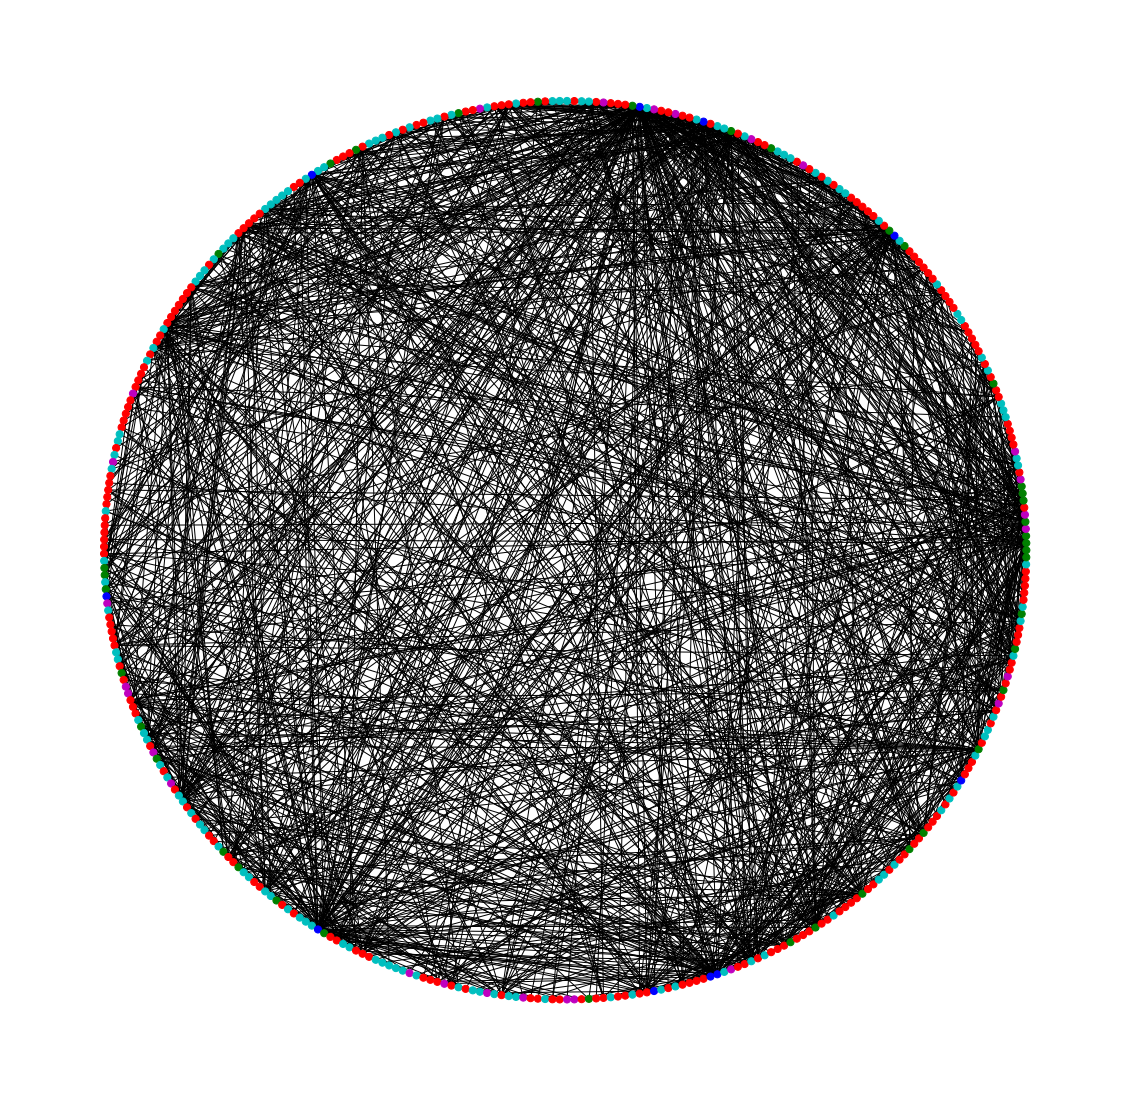

In [14]:
# Create an empty graph
OPEN_ID = nx.Graph()

# Add nodes to the graph
nodes = list(set(df_open['source']).union(set(df_open['target'])))
for node in nodes:
    category1_matches = df_open['source'] == node
    category2_matches = df_open['target'] == node
    if category1_matches.any() or category2_matches.any():
        category1 = df_open.loc[category1_matches, 'type Source'].iloc[0] if category1_matches.any() else None
        category2 = df_open.loc[category2_matches, 'type Target'].iloc[0] if category2_matches.any() else None
        OPEN_ID.add_node(node, category1=category1, category2=category2)

# Add edges to the graph
edges = [(row['source'], row['target']) for index, row in df_open.iterrows()]
OPEN_ID.add_edges_from(edges)

# Define colors for each category
colors = {'user': 'r', 'organization': 'm','opportunity':'c', 'challenge': 'g', 'hub':'b'}

# Create a list of node colors based on their categories
node_colors = [colors[OPEN_ID.nodes[node]['category1']] if OPEN_ID.nodes[node]['category1'] else colors[OPEN_ID.nodes[node]['category2']] for node in OPEN_ID.nodes()]

# Draw the graph with a larger figure size
fig = plt.figure(figsize=(20, 20))
pos = nx.circular_layout(OPEN_ID)
nx.draw_networkx_nodes(OPEN_ID, pos, node_size=50, node_color=node_colors)
nx.draw_networkx_edges(OPEN_ID, pos)
plt.axis('off')
plt.show()


## Create the adjacency matrix of the create graph

In [15]:
m_open_ID = nx.to_pandas_adjacency(OPEN_ID)
m_open_ID.index = OPEN_ID.nodes()
m_open_ID.columns = OPEN_ID.nodes()

### Remove the community's from the rows

In [16]:
for i in range(len(m_open_ID)-1,-1,-1):
    type = GetTypeFromID(m_open_ID.index[i])
    if type == 'hub' or type == 'challenge' or type == 'opportunity':
        m_open_ID = m_open_ID.drop(m_open_ID.index[i])

### Remove the contributors from the columns

In [17]:
for i in range(len(m_open_ID.columns)-1,-1,-1):
    type = GetTypeFromID(m_open_ID.columns[i])
    if type == 'user' or type == 'organization':
        m_open_ID = m_open_ID.drop(m_open_ID.columns[i], axis=1)

Check if there are duplicated users

In [18]:
m_open_ID[m_open_ID.index.duplicated()]

,65c85f11-ff52-4c5f-a16d-16ac9cafca19,bd70b929-1088-4cdd-b383-3844ae343976,329b4f1b-fc0a-4377-90d1-40b13b8948c8,b8960c33-fe86-46fc-9a6e-c99982027e62,32bc3cbc-1129-4014-a100-ccdf2e655430,83b9ee19-e575-4e53-b7ed-456b28ac8b4f,159365e2-027e-4142-ad61-ea096296929d,634401b4-75e7-4533-8a1d-acdd36d4c4e0,f1eae899-2083-4278-970b-143a1c72ac72,c5d5e2ec-2327-4efb-aa97-c48eb230e43e,...,02c25022-8b33-48d3-9578-201c2a303c46,5b65ce97-2a03-4498-8b34-2b5a8ab8dce1,49d317bb-9390-4b60-a71d-ee3146ad6057,8fa6c744-948c-40b6-9733-b03c84c517cb,171b2033-cb9b-4183-abe5-2d96e4493f03,b9bf9e3f-1374-4377-9aa9-c3c0963a5747,a9eeb5ab-0065-4016-ae76-82b952949131,8db45b4a-590b-49c9-801c-3ebd938671f5,7bbd4cf8-5b47-44c7-a419-ff76bebf03f8,3fc401fb-3f7a-4087-a155-0a85cace2e4f


Check if there are duplicated columns

In [19]:
m_open_ID.columns.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

Check if there are duplicated user names. If so, combine the community's of these users so there is only one user with that name in the dataframe. Therefor first create the dataframe with the ID, name, group and type of all the users. To see how go to:

In [20]:
data = pd.read_csv('ID_name_group_type_2023.csv', index_col=0)

In [23]:
new_index = [GetNameFromID(name) for name in m_open_ID.index]
newlist = [] 
duplist = [] 
for i in new_index:
    if i not in newlist:
        newlist.append(i)
    else:
        duplist.append(i) 

In [24]:
for i in range(len(duplist)):
    items2 = []
    IDS = data[data['name']==duplist[i]]['ID'].to_list()
    for x in range(len(IDS)):
        items1 = GetMemberItems(m_open_ID, IDS[x])
        items2.append(items1)
    items = flatten(items2)
    ID_keep = IDS[0]

    all_columns = list(m_open_ID.columns)
    user_dict = dict.fromkeys(all_columns, 0)

    for item in items:
        user_dict[item] = 1

    active_user = pd.DataFrame(data=[user_dict], columns=all_columns, index=[ID_keep])
    m_open_ID=m_open_ID.drop(IDS)
    m_open_ID=m_open_ID.append(active_user)

Now you have created a dataframe with all the connections on the platform

Check if removing the duplicated users went well. The list of duplicates should be empty now

In [25]:
new_index = [GetNameFromID(name) for name in m_open_ID.index]
newlist = [] 
duplist = [] 
for i in new_index:
    if i not in newlist:
        newlist.append(i)
    else:
        duplist.append(i) 
print("List of duplicates", duplist)

List of duplicates []


Safe the created dataframe

In [25]:
m_open_ID.to_csv('Prediction_matrix_2023.csv')

In [26]:
df = pd.read_csv('Prediction_matrix_2023.csv', index_col=0)